# Visual Gradiente

In [1]:
import numpy as np
import tensorflow as tf
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [2]:
# Cargar el modelo ResNet50 preentrenado en ImageNet
model = ResNet50(weights='imagenet')

# Mostrar la arquitectura del modelo
model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [3]:
def cargar_imagen_nifti(img_ruta, slice_index=None, img_size=(224,224)):
   # Cargar el archivo NIfTI (.nii o .nii.gz)
   nifti_img = nib.load(img_ruta)
   # Obtener los datos en formato NumPy
   img_data = nifti_img.get_fdata()

   # Si no se especifica un índice de corte, usar el corte central
   if slice_index is None:
      slice_index = img_data.shape[2] // 2 # Usar el corte axial central

   # Seleccionar una rebanada específica de la imagen (corte axial)
   img_slice = img_data[:,:,slice_index]
   # Redimensionar la imagen al tamaño que espera ResNet50 (224x224)
   img_slice_resized = cv2.resize(img_slice, img_size)
   # Normalizar los valores y expandir la dimensión del batch
   img_slice_resized = np.stack([img_slice_resized]*3, axis=1) # Convertir a 3 canales (RGB)
   img_slice_resized = preprocess_input(img_slice_resized) # Preprocesar como espera ResNet50 
   img_slice_resized = np.expand_dims(img_slice_resized, axis=0) # Añadir dimensión de batch
   return img_slice_resized, img_slice

In [4]:
def estimar_gradcam(modelo, img_array, nom_ult_capa_conv, pred_index=None):
   # Crear un modelo que mapea la imagen de entrada a las activaciones de la capa convolucional final
   grad_model = Model(
      [modelo.inputs],
      [modelo.get_layer(nom_ult_capa_conv).output, modelo.output]
   )

   # Pasar la imagen a través del modelo para obtener la activación y la predicción
   with tf.GradientTape() as tape:
      salida_ult_capa_conv, preds = grad_model(img_array)
      if pred_index is None:
         pred_index = tf.argmax(preds[0])
      class_channel = preds[:, pred_index]

   # Calcular los gradientes de la clase objetivo con respecto a la salida de la última capa convolucional
   grads = tape.gradient(class_channel, salida_ult_capa_conv)

   # Calcular el promedio de los gradientes a lo largo del eje de profundidad
   pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

   # Multiplicar cada canal de la salida de la última capa convolucional por el gradiente promedio
   salida_ult_capa_conv = salida_ult_capa_conv[0]
   heatmap = salida_ult_capa_conv @ pooled_grads[..., tf.newaxis]
   heatmap = tf.squeeze(heatmap)

   # Aplicar ReLU para dejar solo las contribuciones positivas
   heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
   return heatmap.numpy()

In [5]:
def superposicion_gradcam_sobre_nifti(img_slice, heatmap, intensity=0.4):
   # Redimensionar el heatmap para que coincida con el tamaño de la imagen original
    heatmap_resized = cv2.resize(heatmap, (img_slice.shape[1], img_slice.shape[0]))
    
    # Normalizar el heatmap entre 0 y 255
    heatmap_resized = np.uint8(255 * heatmap_resized)
    
    # Aplicar colorización al heatmap (opcional)
    heatmap_colored = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    
    # Convertir la imagen de NIfTI a RGB para superponer (duplicar canal para simular RGB)
    img_slice_rgb = cv2.cvtColor(np.uint8(255 * img_slice / np.max(img_slice)), cv2.COLOR_GRAY2RGB)
    
    # Superponer el heatmap sobre la imagen original
    superimposed_img = cv2.addWeighted(heatmap_colored, intensity, img_slice_rgb, 1 - intensity, 0)
    
    return superimposed_img

Forma de la imagen: (1, 224, 3, 224)
Forma de la imagen: (1, 224, 224, 3)


/Users/shiguihara/miniforge3/envs/visualgradiente/lib/python3.11/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: [['keras_tensor']]. Received: the structure of inputs=*
  warnings.warn(


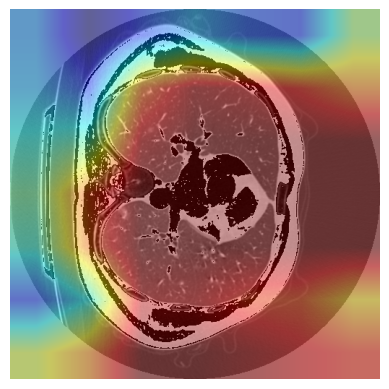

In [6]:
# Cargar la imagen de la tomografía en formato NIfTI
img_path = './study_0304_0000.nii.gz'
img_array, img_slice = cargar_imagen_nifti(img_path)
print("Forma de la imagen:", img_array.shape)
# Cambiar los ejes de (1, 224, 3, 224) a (1, 224, 224, 3)
img_array = np.transpose(img_array, (0, 2, 3, 1))
# Asegúrate de que la imagen tiene la forma correcta
print("Forma de la imagen:", img_array.shape)

# Obtener el heat map de Grad-CAM
last_conv_layer_name = 'conv5_block3_out'  # Capa convolucional final de ResNet50
heatmap = estimar_gradcam(model, img_array, last_conv_layer_name)

# Superponer el heat map sobre la imagen de NIfTI
superimposed_img = superposicion_gradcam_sobre_nifti(img_slice, heatmap)

# Mostrar la imagen superpuesta
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()